# 3. 量子テレポーテーション

Created by Kifumi Numata (Apr 26, 2024)
Translated by Shiori Aoki (Jun 17, 2025)

和訳版の講義スライドPDFは[こちら](https://github.com/quantum-tokyo/introduction/blob/main/src/courses/utility-scale-quantum-computing/3_teleportation.pdf)です。

*Approximate QPU time to run this experiment is 10 seconds.*

## 1. 序論

実用的な規模の量子問題を解決するためには，量子コンピュータ上で情報をある量子ビットから別の量子ビットへと移動させる必要があります．そのためのプロトコルはよく知られていますが，最も基礎的なもののいくつかは遠く離れた者同士の間で情報を送るという文脈で使われています．このレッスンでは，「遠く離れた友人が情報を送る」というような，この文脈に沿った言葉を使うことがありますが、これらのプロトコルは量子コンピューティングにおいてより広い意味を持っていることを留意してください．このレッスンでは、以下の量子通信プロトコルを考えます．：
- **量子テレポーテーション**    
    共有されたもつれ状態（e-bitと呼ばれることもある）を使って，未知の量子状態を遠くの友人に送信する．
- **量子超密度符号化**    
    1つの量子ビットを遠方の友人に送信して2ビットの情報を送信する方法（ここでも事前に共有されたもつれ量子ビットを使用）

これらのトピックに関連する背景については，下記リンクの「Basics of Quantum Information」第四章を参照してください．
[Entanglement in Action](https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action). 

上記の説明では、「未知の量子状態」とは、単に前のレッスンで説明した形式の状態を指します：
$$|\psi\rangle =\alpha|0\rangle+\beta|1\rangle$$
ただし $\alpha$ と $\beta$ はそれぞれ$|\alpha|^2+|\beta|^2 = 1$となるような複素数です．これにより，量子状態は以下のように表現できます．
$$|\psi\rangle =\cos\frac{\theta}{2}|0\rangle+e^{i\varphi}\sin\frac{\theta}{2}|1\rangle= 
\left(
\begin{matrix}
\cos\frac{\theta}{2}\\
e^{i\varphi}\sin\frac{\theta}{2}
\end{matrix}
\right)
.$$
どのようなランダムな量子状態でも情報を転送できるようにしたいので，そのような状態を生成するところからこのレッスンを始めます．

## 2. 密度行列

量子状態$|\psi \rangle$ を密度行列として書くことができます．この形式は純粋量子状態の確率的混合を表すのに便利です．単一量子ビットの場合，次のように書けます．

$$|\psi \rangle \langle \psi| \equiv  \rho = \left(
\begin{matrix}
\cos\frac{\theta}{2}\\
e^{i\varphi}\sin\frac{\theta}{2}
\end{matrix}
\right) 
\left(
\begin{matrix}
\cos\frac{\theta}{2} & e^{-i\varphi}\sin\frac{\theta}{2}
\end{matrix}
\right)
=\frac{1}{2}\left(\begin{matrix}
1+\cos\theta & e^{-i\varphi}\sin\theta\\
e^{-i\varphi}\sin\theta & 1-\cos\theta
\end{matrix}\right)$$
ただし，密度行列$\rho$は下記のようにPauli行列の線形和であることに注意してください．

$$\rho = \frac{1}{2}\bigl( \textbf{I} + (\sin{\theta}\cos{\varphi})\textbf{X}+  (\sin{\theta}\sin{\varphi})\textbf{Y} +  (\cos{\theta})\textbf{Z} \bigr)$$

もしくは一般的に以下のようになります．

$$\rho = \frac{1}{2}(\textbf{I} + r_{x}\textbf{X}+ r_{y}\textbf{Y} + r_{z}\textbf{Z})$$
ただし，$r_{x}$,$r_{y}$,$r_{z}$は以下の通りです．
$r_{x}^2+r_{y}^2+r_{z}^2=1$.

Blochベクトルはこのようになります．
$\textbf{r} = (r_{x}, r_{y}, r_{z})$

では，乱数を用いて任意の量子状態を作ってみましょう． 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
#rベクトルを定義するために，ランダムな(θ, varphi)からランダムな1量子ビット状態を作成する．
np.random.seed(1) #fixing seed for repeatibility

theta = np.random.uniform(0.0, 1.0) * np.pi    #from 0 to pi
varphi = np.random.uniform(0.0, 2.0) * np.pi    #from 0 to 2*pi

def get_r_vec(theta, varphi):
    rx = np.sin(theta) * np.cos(varphi)
    ry = np.sin(theta) * np.sin(varphi)
    rz = np.cos(theta)
    return (rx, ry, rz)

# rベクトルを得る．
rx, ry, rz = get_r_vec(theta, varphi)

print("theta="+str(theta), ",varphi="+str(varphi))
print("(rx, ry, rz) = (" + str(rx) + ", " + str(ry) + ", " + str(rz) + ")")

theta=1.3101132663588946 ,varphi=4.525932273597346
(rx, ry, rz) = (-0.1791150283307452, -0.9494670044331133, 0.2577405946274022)


ブロッホ球上のブロッホベクトルを見ることができます。

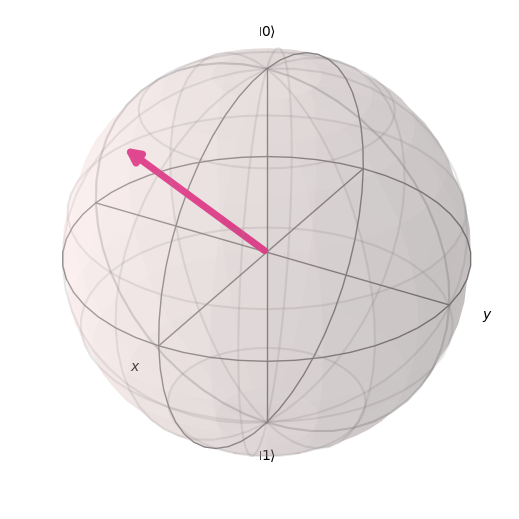

In [7]:
from qiskit.visualization import plot_bloch_vector
r = [rx, ry, rz]
plot_bloch_vector(r)

## 3. 量子トモグラフィー

計算基底($|0 \rangle$ and  $|1 \rangle$)で量子状態を測定するのならば，位相情報(複素数情報)は失われます．しかしながら，準備過程を繰り返して$|\psi \rangle$ のコピーが複数あれば，(状態の複製は作れないが，準備過程を繰り返すことはできる),密度行列$\rho$に対して量子状態トモグラフィーを行うことで $r_{x},r_{y}, r_{z}$の値を推定できます．

$$ \rho = \frac{1}{2}(\textbf{I} + r_{x}\textbf{X}+ r_{y}\textbf{Y} + r_{z}\textbf{Z})$$


$$Tr(\textbf{X} \rho) =  r_{x}, \quad Tr(\textbf{Y} \rho) =  r_{y}, \quad Tr(\textbf{Z} \rho) =  r_{z} $$

$r_{z}$に対して，以下のようになります．

$$Tr(\textbf{Z} \rho) =  \langle 0|\textbf{Z} \rho|0 \rangle +  \langle 1|\textbf{Z} \rho|1 \rangle $$
$$ = \langle 0|(|0 \rangle\langle 0|-|1 \rangle\langle 1|) \rho|0 \rangle +\langle 1|(|0 \rangle\langle 0|-|1 \rangle\langle 1|) \rho|1 \rangle $$
$$=\langle 0|\rho|0 \rangle- \langle 1| \rho|1 \rangle $$
$$=\langle 0|\psi\rangle\langle \psi|0 \rangle -  \langle 1| \psi\rangle\langle \psi|1 \rangle $$
$$=|\alpha|^2-|\beta|^2  $$

等式の最後の変形は $|\psi \rangle  =\alpha|0\rangle+\beta|1\rangle$に対するものです．したがって，$r_{z}$は$|0 \rangle$  - $|1 \rangle$の確率で求めることができます．

### $r_z$の推定

$r_z$を推定するために，量子状態を作り，それを測定します．この準備と測定を何度も繰り返し，この測定の統計を用いることで上記の確率を測定し，$r_z$を推定します．

ランダムな量子状態を作り出すために，一般的なユニタリゲート$U$をパラメータ$ \theta, \varphi$と用います．(詳細な情報は下記リンクを参照[U-gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.UGate.html))

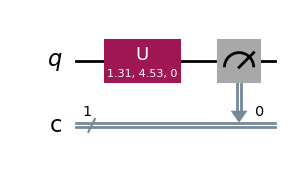

In [8]:
from qiskit import QuantumCircuit

#1qubitの量子状態psiをtheta, varphi から作る
qc = QuantumCircuit(1, 1)
qc.u(theta, varphi, 0.0, 0)

#計算基底を測定する
qc.measure(0,0)

qc.draw(output="mpl")

 `AerSimulator`を使うことで,  $r_z$を推定するための計算規定を求めることができます.

In [ ]:
# 計算基底の期待値を見る 
# rzの極限に近づく
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler

# backendを定義
backend = AerSimulator()
nshots = 1000 # or 10000
#nshots = 10000

# backendのトランスパイル
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# jobの実行
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

# 計測結果の抽出
counts = result[0].data.c.get_counts()
print(counts)

# ヒストグラムでのプロット
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [ ]:
rz_approx = (counts['0'] - counts['1'])/nshots

print("rz = ", rz, " and approx of rz = ", rz_approx)

量子トモグラフィーを用いて，$r_z$ の値を推定しました．このケースにおいて"ランダム"な状態のパラメータを選んだため，$r_z$の値を知り確認することができます．しかしその性質上，ユーティリティスケールの事は必ずしも確認が簡単ではありません．量子状態の測定結果の確認についてはこのコースの後半で議論します．今のところは，我々の測定がそれなりに正確であったことだけを認識しておきましょう．

### Exercise 1: $r_x$ の値の推定
IBMの量子コンピュータが$z$軸に沿って測定を行ったことを思い出してください． ($z$基底もしくは計算基底と表記されることもあります．)しかしながら，測定の前に回転を使えば，量子状態の$x$軸への射影も測定できます．より正確には，$x$軸を指していたものが$z$軸を指すように系を回転させれば，$z$軸に沿った測定ハードウェアを維持したまま，$x$軸に沿っていた状態を知ることができます．これがIBMの全ての量子コンピュータを含むほとんどの量子コンピュータが複数の軸に沿って測定を行う方法です．

これを理解した上で，量子トモグラフィーを用いて$r_x$の値を推定するコードを書いていきましょう．

__Solution__:

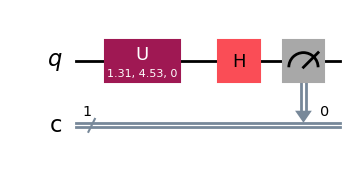

In [10]:
#1qubitの量子状態psiをtheta, varphi から作る
qc = QuantumCircuit(1, 1)
qc.u(theta, varphi, 0.0, 0)

qc.h(0)
qc.measure(0,0)

qc.draw(output="mpl")

{'1': 5900, '0': 4100}


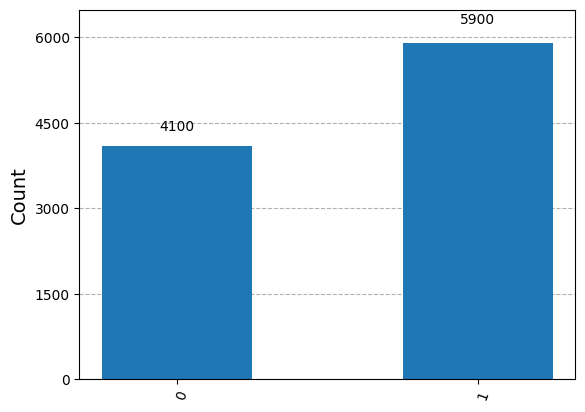

In [11]:
# backendの定義
backend = AerSimulator()
nshots = 10000

# backendのトランスパイル
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# jobの実行
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

# 計測結果の抽出
counts = result[0].data.c.get_counts()
print(counts)

# ヒストグラムのプロット
plot_histogram(counts)

In [12]:
rx_approx = (counts['0'] - counts['1'])/nshots

print("rx = ", rx, " and approx of rx = ", rx_approx)

rx =  -0.1791150283307452  and approx of rx =  -0.18


### Exercise 2: $r_y$の値の推定
先ほどと同じ論理を用いれば，測定前に系を回転させて$r_y$について知ることができます． 
量子状態トモグラフィーを使って$r_y$の値を推定するコードを書いていきましょう．前の例から始めても良いですが．回転を変えてみましょう．(```sdg```を含む使用されている様々なゲートについての詳細は以下リンクを参照 [this](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#sdg).)

__Solution__:

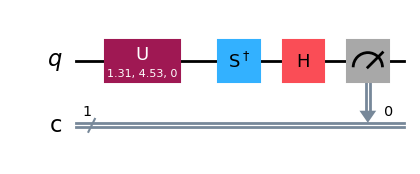

In [ ]:
#1-qubit の量子状態 psi をtheta, varphiパラメータから作成
qc = QuantumCircuit(1, 1)
qc.u(theta, varphi, 0.0, 0)

qc.sdg(0)
qc.h(0)
qc.measure(0,0)

qc.draw(output="mpl")

{'1': 9755, '0': 245}


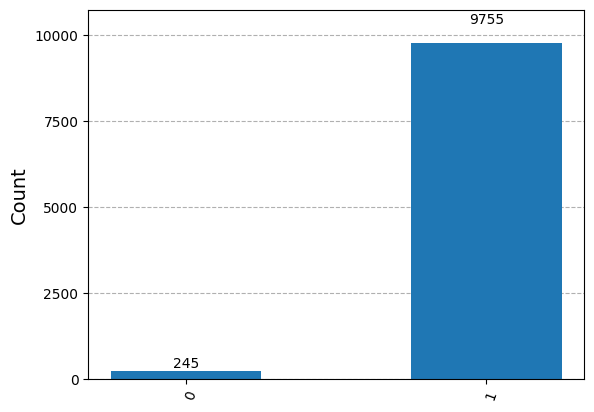

In [ ]:
# backendの定義
backend = AerSimulator()
nshots = 10000

# backendのトランスパイル
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# jobの実行
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

# データの抽出
counts = result[0].data.c.get_counts()
print(counts)

#ヒストグラムでのプロット
plot_histogram(counts)

In [15]:
ry_approx = (counts['0'] - counts['1'])/nshots

print("ry = ", ry, " and approx of ry = ", ry_approx)

ry =  -0.9494670044331133  and approx of ry =  -0.951


$\vec{r}$の全成分を推定したので，全ベクトルを書き出すことができます．

In [16]:
print("Estimated vector is (", rx_approx,",",ry_approx,",",rz_approx,").")
print("Original random vector was (" + str(rx) + ", " + str(ry) + ", " + str(rz) + ").")

Estimated vector is ( -0.18 , -0.951 , 0.246 ).
Original random vector was (-0.1791150283307452, -0.9494670044331133, 0.2577405946274022).


この量子トモグラフィーを使えば，かなり正確に元のランダムなベクトルを推定することができます．

## 4. 量子テレポーテーション

キャラクターAliceが未知の量子状態$|\psi \rangle$を遠くにいる友人Bobに送りたい場合を考えましょう．2人は古典的な通信（電子メールや電話など）しかできないと仮定します．Aliceは量子状態をコピーできません（クローン禁止定理）．もしAliceが同じ準備プロセスを何度も繰り返せば，先ほどのように統計量を積み上げることができます．しかし，未知の状態が1つしかない場合はどうでしょうか．この状態は，あなたが研究したい物理的プロセスから出現したものかもしれません．あるいは，より大きな量子計算の一部かもしれません．その場合，Aliceはどうやってその状態をBobに送ることができるでしょうか？もしAliceとBobが貴重な量子リソース（前のレッスンで紹介したベル状態のような共有もつれ状態： $\frac {|00\rangle + |11\rangle}{\sqrt 2}$ これを 「EPRペア」あるいは 「e-bit」（もつれの基本単位）と呼ぶこともあります．）を共有すれば，それは可能です．もしAliceがこのようなもつれた状態をBobと共有すれば，一連の量子操作を行い，2ビットの古典情報を送ることで，未知の量子状態をBobに*テレポート*することができます。

### 4.1 量子テレポーテーションのプロトコル
**仮定**: AliceはBobに送る未知の量子状態$|\psi \rangle$を持っている．AliceとBobは2量子ビットのもつれた状態（e-bit）を共有し，それぞれが物理的に1つの量子ビットを自分の場所に持っている．

ここではその手順の概略を説明します．これらは以下で詳細に実施されます．
1. AliceはCNOTゲートを使って$|\psi \rangle$をe-bitの自分の一部とエンタングルする．
2. Aliceは$|\psi \rangle$にアダマールゲートを適用し計算基底で両者の量子ビットを測定する．
3. AliceBobに測定結果（「00」，「01」，「10」，「11」のいずれか）を送る．
4. BobはAliceの2ビットの情報に基づいて，eビットペアの自分の部分に*補正*演算を行う．
    - もし“00”ならば，Bobは何もしない．
    - もし“01”ならば，BobはXゲートを適用する．
    - もし“10”ならば，BobはZゲートを適用する．
    - もし“11”ならば，BobはiY = ZXゲートを適用する．
5. Bobのe-bitが$|\psi \rangle$となる．

詳細は下記リンクにあります．[Basics of Quantum Information](https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action#teleportation)
Qiskitでインスタンス化することで明確にします．

### 4.2 量子テレポーテーションをシミュレートする量子回路

この章ではマッピングにのみ焦点を当てます．

### Step 1: 量子回路と演算子へのマッピング問題

このシナリオを説明するためには，3つの量子ビットをもつ量子回路が必要です．２つはAliceとBobが共有するエンタングルされたペアであり，もう１つは未知の量子状態$|\psi\rangle$です．

In [10]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import matplotlib.pyplot as plt

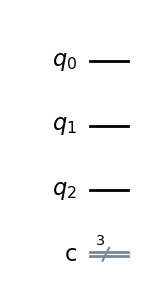

In [ ]:
# 3-qubits 量子回路の作成
qc = QuantumCircuit(3,3)    

qc.draw(output="mpl")

初めに，Aliceは未知の量子状態 $|\psi \rangle$を持っています．この状態を$U$ゲートを用いて再現します．

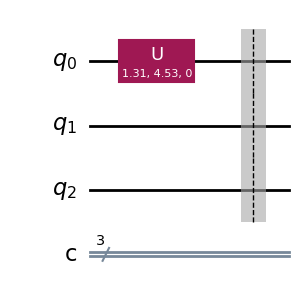

In [ ]:
# u-gateを用いてAlice のもつ未知の量子状態を作成.
qc.u(theta, varphi, 0.0, 0)
qc.barrier()    # for visual separation

qc.draw(output="mpl")

この状態を可視化できるのは，$U$ゲートでどのようなパラメータが使われたかを知っているからです．もしこの状態が複雑な量子プロセスから生まれたものであれば，状態を作り出すプロセスを何度も実行しトモグラフィーのように統計量を集めなければ状態を知ることはできないでしょう．

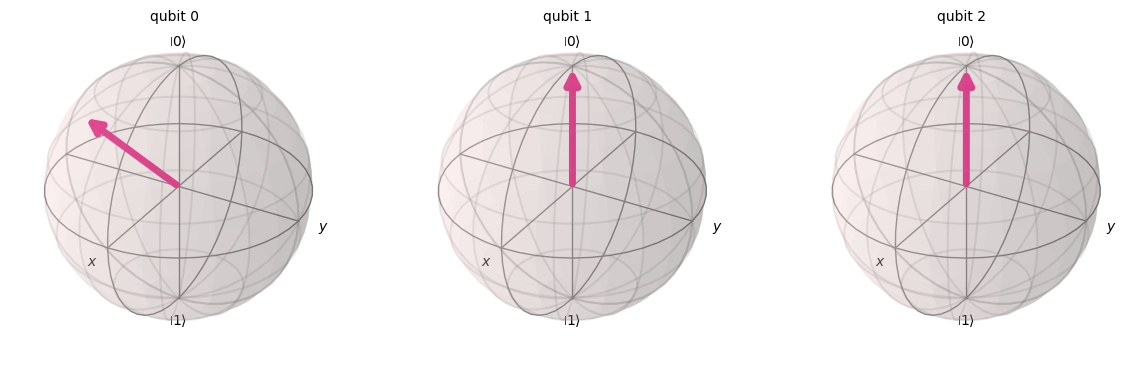

In [ ]:
# bloch球での量子状態の可視化
from qiskit.quantum_info import Statevector
out_vector = Statevector(qc)

from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(out_vector)

このプロトコルが始まる前に，AliceとBobが共有されたエンタングルのペアを持っていると仮定します．AliceとBobが本当に違う場所にいるならば，未知の状態$|\psi\rangle$ が作成される前に共有状態を設定したかもしれません．これらのことは異なる量子ビット上で起きているので，ここでの順序は問題ではなく．可視化するのに便利なようになっています．

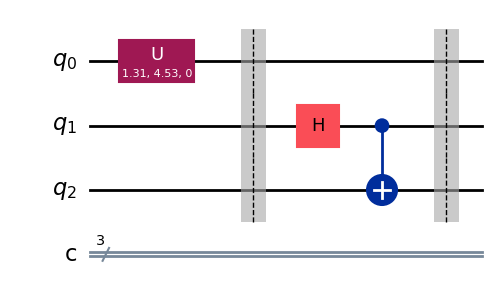

In [ ]:
# AliceとBob同じ場所にいて、エンタングルのペアを作成.
qc.h(1)
qc.cx(1, 2)
qc.barrier()    # for visual separation.
# We can consider that Alice and Bob may move their qubits to different physical locations, now.

qc.draw(output="mpl")

つぎに，$CX$ゲートと$H$ゲートを用いてAliceは$|\psi \rangle$を共有されたe-bitとエンタグルさせ，計算基底において測定を行います．

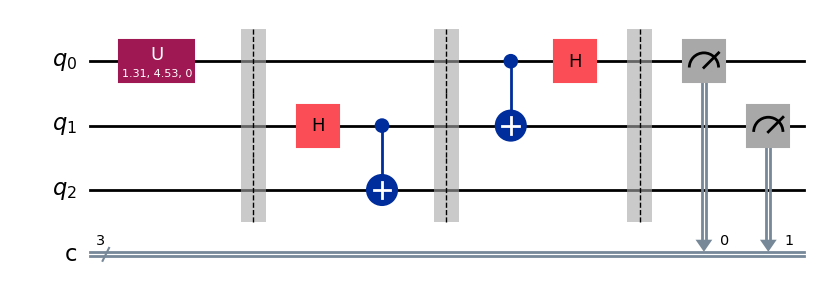

In [ ]:
# Aliceは未知の量子状態を共有されたe-bitとエンタングルさせる
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Alice measures the two qubits.
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw(output="mpl")

AliceはBobに自分の測定結果(either “00”, “01”, “10”，“11”のいずれか)を送り，Bobは共有されたe-bitの自分の部分にAliceの2ビットの情報に基づいた補正演算を行います．すると，Bobの測定結果は$|\psi \rangle$になります．

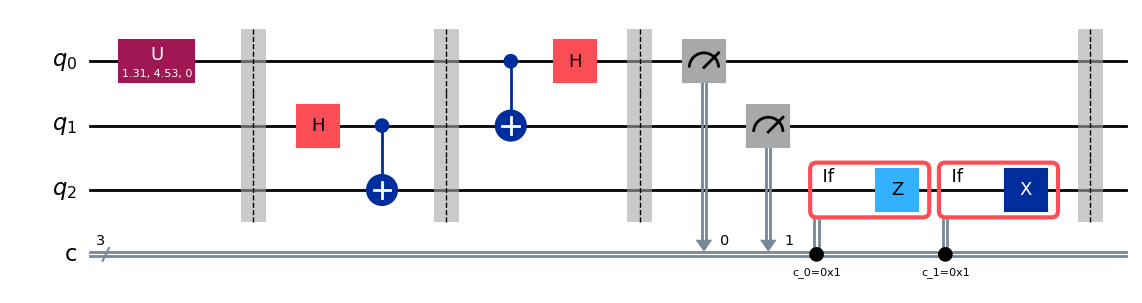

In [ ]:
# Aliceは結果をBobに送る. Bobは補正結果を受け入れる。
with qc.if_test((0, 1)):   
    qc.z(2)
with qc.if_test((1, 1)):
    qc.x(2)
qc.barrier()

qc.draw(output="mpl")

量子テレポーテーション回路が完成しました．状態ベクトルシミュレータを用いてこの回路の出力状態を見てみましょう．

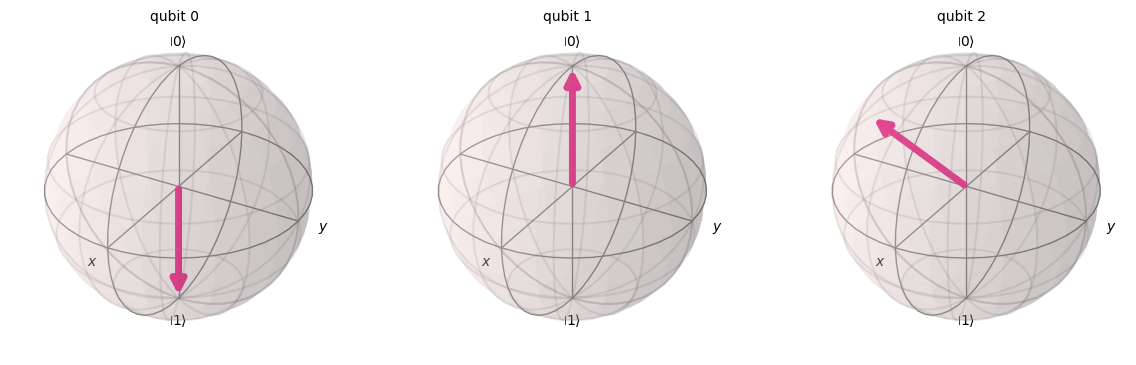

In [25]:
from qiskit_aer import StatevectorSimulator
backend = StatevectorSimulator()
out_vector = backend.run(qc, shots=1).result().get_statevector()    # set shots = 1

plot_bloch_multivector(out_vector)

量子ビット0（もともと秘密の状態を保持していた量子ビット）の$U$ゲートによって作られた量子状態が量子ビット2（Bobの量子ビット）に転送されているのが分かります．

上記のセルを数回実行して確かめましょう．量子ビット0と1は状態が変わりますが，量子ビット2は常に $\psi\rangle $の状態であることに気づくかもしれません．

### 4.3 実行しUの逆数を適用して結果を確認する

上記ではテレポートされた状態が正しく見えることを目視で確認しました．量子状態が正しくテレポートされたかどうかを確認するもう一つの方法は，Bobの量子ビットに$U$ゲートの逆数を適用し『0』を測定できるようにすることです．つまり，$U^{-1}U$は恒等式なので，Bobの量子ビットが$U|0\rangle,$から生成された状態にある場合，逆数を適用すると$U^{-1}U|0\rangle=|0\rangle.$が得られるはずです．

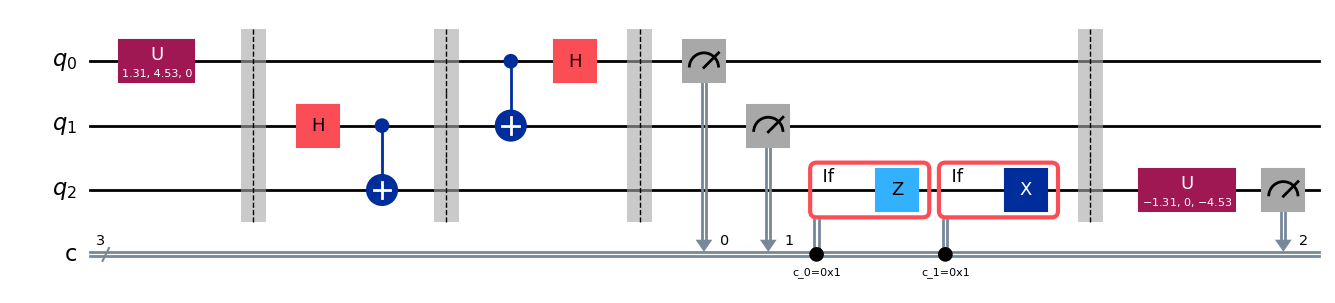

In [26]:
# Apply the inverse of u-gate to measure |0>   
qc.u(theta, varphi, 0.0, 2).inverse()    # inverse of u(theta,varphi,0.0)
qc.measure(2, 2) # add measurement gate

qc.draw(output="mpl")

実際の量子計算機に移る前にまずAerSimulatorを使って回路を実行します.


{'011': 2553, '000': 2526, '010': 2525, '001': 2396}


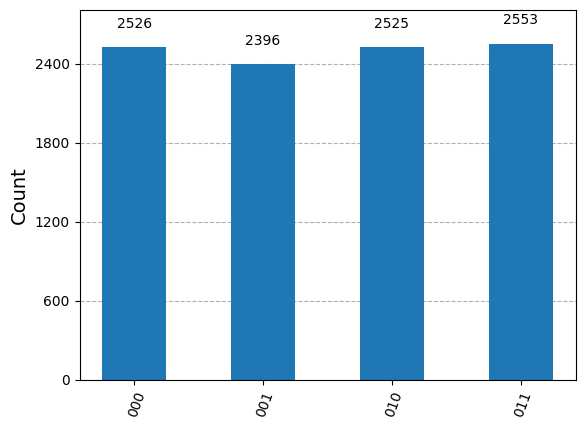

In [27]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_histogram

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# Run the job
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()

# Extract counts data
counts = result[0].data.c.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

little endian表記では，qubit2が一番左（列ラベルでは一番下）のqubitであることを思い出してください．列ラベルの一番左/一番下の量子ビットは，すべての可能な結果に対して0であることに注意してください．これは$q_2$を100%の確率で$|0\rangle $の状態で測定できることを示しています．これは期待された結果であり，テレポーテーションプロトコルが正しく機能したことを示しています．

### 4.4 量子コンピュータ実機での量子テレポーテーション

次に実際の量子コンピュータ上でテレポーテーションを実行します．動的回路機能を使うことで，計測結果を使って回路の途中で操作することができ，テレポーテーション回路の条件演算をリアルタイムに実装することができます．実際の量子コンピュータで問題を解くには，Qiskit Patternsの4つのステップに従います．

    1. 量子回路と演算子への写像問題
    2. ターゲットハードウェアに最適化する
    3. ターゲットハードウェア上での実行
    4. 結果の後処理

### Exercise 3: テレポーテーション回路の設計

テレポーテーション回路全体をゼロから組み立てて理解度を試してみましょう．

__Solution__:

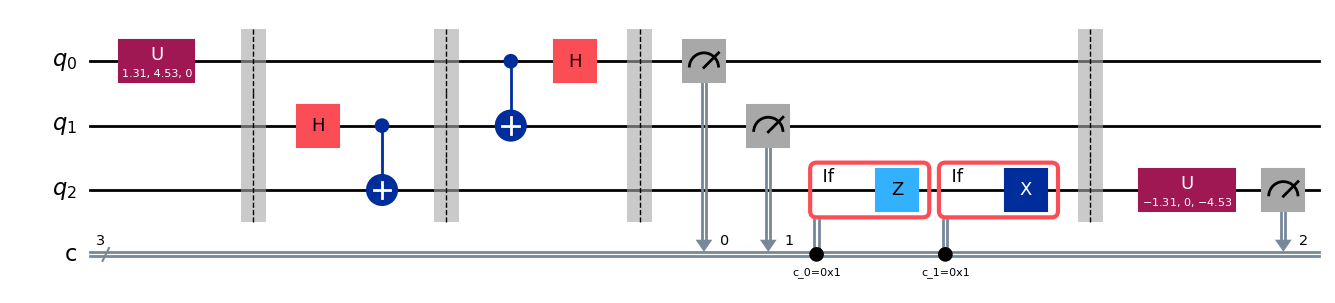

In [ ]:
# Step 1: Map problem to quantum circuits and operators
# Create the circuit with 3-qubits and 1-bit
qc = QuantumCircuit(3,3)    

# Alice creates an unknown quantum state using the u-gate.
qc.u(theta, varphi, 0.0, 0)
qc.barrier()    # for visual separation

# Eve creates EPR pair and sends q1 to Alice and q2 to Bob
##your code goes here##
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# Alice entangles the unknown state with her EPR part, using the CNOT gate & H gate.
##your code goes here##
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Alice measures the two qubits.
##your code goes here##
qc.measure(0, 0)
qc.measure(1, 1)

# Alice sent the results to Bob. Now, Bob applies correction
##your code goes here##
with qc.if_test((0, 1)):
    qc.z(2)
with qc.if_test((1, 1)):
    qc.x(2)
qc.barrier()

# Apply the inverse of u-gate to measure |0>   
qc.u(theta, varphi, 0.0, 2).inverse()    
qc.measure(2, 2)

qc.draw(output="mpl")

注意点として，$U$ゲートの逆ゲートを適用するのは期待される振る舞いを検証するためです．量子情報の転送だけが目的なら$U$ゲートの逆は使いません．

### Step 2: ターゲットハードウェアへの最適化

ハードウェア上で実行するために，`QiskitRuntimeService`をimportし，IBM量子チャネルの保存された資格をロードします． そして，キュー内のジョブ数が最も少ないバックエンドを選択します．

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# If this is your first time running your circuit on a real device, 
# make sure you copy your API Token from [IBM Quantum Platform](https://quantum.ibm.com/) 
# QiskitRuntimeService.save_account(token='<your_token>', overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")
service.backends()

In [26]:
#You can also identify the least busy device
backend = service.least_busy(operational=True)
print("The least busy device is ", backend)

The least busy device is  <IBMBackend('ibm_nazca')>


In [27]:
# You can specifiy the device 
backend = service.backend('ibm_sherbrooke')

選択したデバイスのカップリング・マップを見てみましょう．

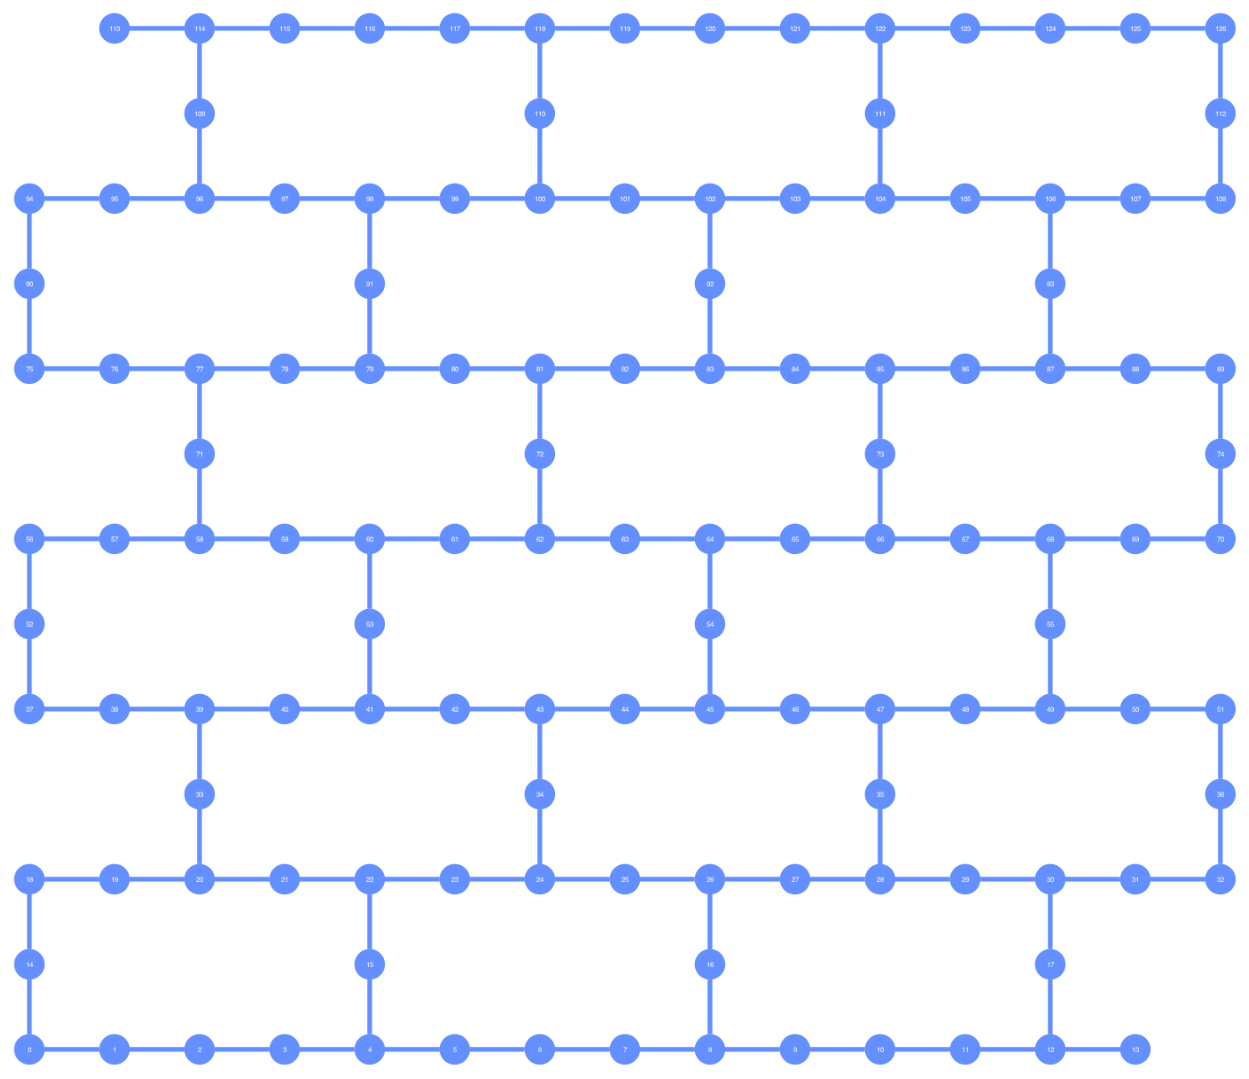

In [28]:
from qiskit.visualization import plot_gate_map
plot_gate_map(backend)

異なるデバイスは異なるカップリングマップを持つかもしれません．また，各デバイスには他よりも性能の高い量子ビットやカップラーがあります．最後に，異なる量子コンピュータは異なる*native gates* （ハードウェアが実行可能なゲート）を持っているかもしれません．回路をトランスパイルすることで，ターゲットとなる量子コンピュータが実行可能なゲートを用いて抽象量子回路を書き換え，物理量子ビットへの最適なマッピングを選択します．（中略）トランスパイルの詳細については下記リンク[documentation](https://docs.quantum.ibm.com/api/qiskit/transpiler#overview)を参照してください．

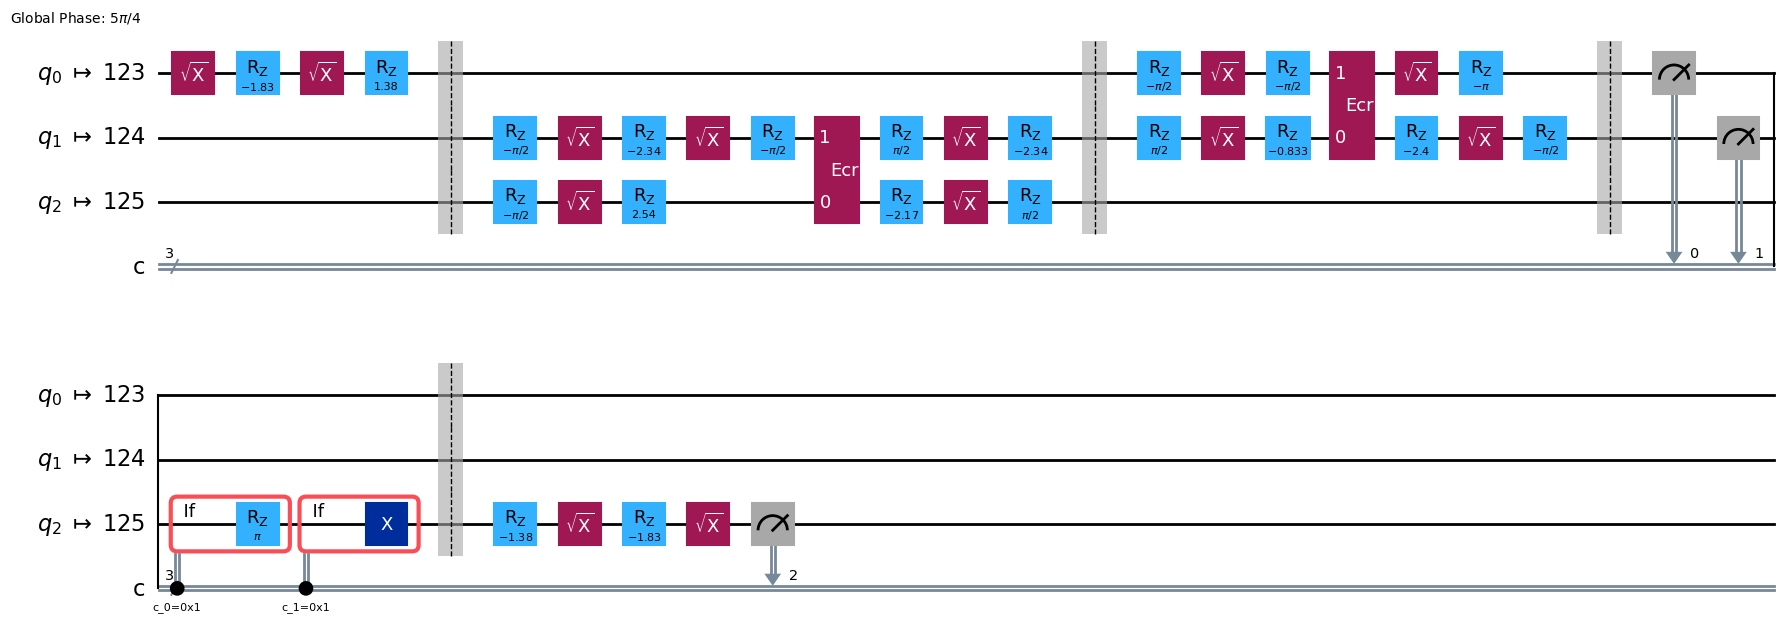

In [ ]:
# Step 2: Optimize for target hardware
# Transpile the circuit into basis gates executable on the hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qc)

qc_compiled.draw("mpl", idle_wires=False)

### Step 3: 回路の実行

`Sampler`を用いてターゲット回路を実行しましょう．

In [29]:
# Step 3: Execute the target circuit
sampler = Sampler(backend)
job = sampler.run([qc_compiled])

print("job id:", job.job_id()) 

job id: cvn758n82hx0008489jg


In [30]:
# Check the job status
job.status()

'RUNNING'

jobのステータスはIBM Quantum Dashboardからも確認可能です：https://quantum.ibm.com/jobs

In [31]:
# If the Notebook session got disconnected you can also check your job statuse by running the following code
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService() 
job_real = service.job('cvn758n82hx0008489jg') # Input your job-id between the quotations
job_real.status()

'DONE'

`'DONE'`と表示されたら，以下のセルを実行すれば結果が得られます．

In [32]:
# Execute after 'DONE' is displayed
result_real = job_real.result()
print(result_real[0].data.c.get_counts())

{'010': 769, '001': 948, '011': 773, '000': 910, '111': 232, '100': 132, '110': 219, '101': 113}


### Step 4: 結果の後処理

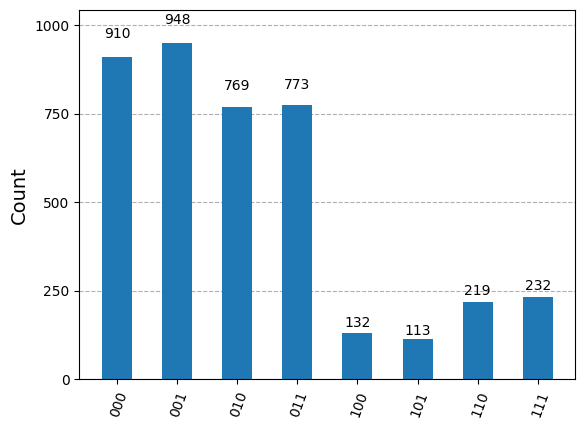

In [ ]:
# Step 4: Post-process the results
from qiskit.visualization import plot_histogram
plot_histogram(result_real[0].data.c.get_counts())

上記の結果を直接解釈することができます．あるいは，`marginal_count`を用いればBobの量子ビットの結果をトレースすることができます．

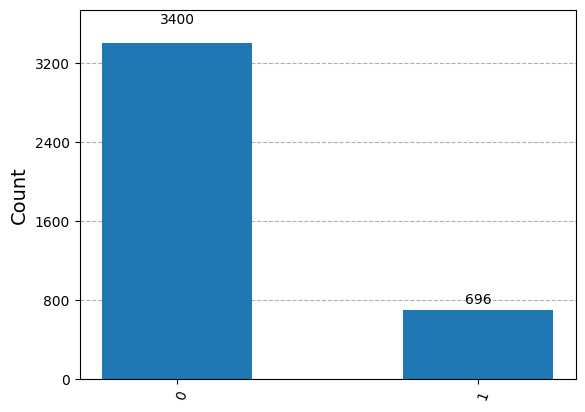

In [34]:
# trace out Bob's results on qubit 2
from qiskit.result import marginal_counts
bobs_qubit = 2
real_counts = result_real[0].data.c.get_counts()
bobs_counts = marginal_counts(real_counts, [bobs_qubit])
plot_histogram(bobs_counts)

このように，$|1 \rangle$を測定した結果がいくつかあります．これらはノイズや誤差によるものです．特に，動的回路は途中の測定2時間がかかるため，誤差が大きくなる傾向にあります．

### 4.5 量子テレポーテーションの要点

もつれた量子ビットのペアを共有することで，量子状態を遠くの友人に転送することができました．

1.量子テレポーテーションは光よりも早く量子状態を送ることができるのでしょうか？

　いいえ．Aliceは古典的な方法で測定結果をBobに伝えなければならないためです．

2.量子テレポーテーションは量子状態のコピーを禁じる「クローン禁止の定理」を破るでしょうか

いいえ．Aliceの量子ビットの１つに与えられたもとの量子状態が測定により失われたからです．$|0\rangle$か$|1\rangle$の状態になってしまいます．
        

## 5. 超密度符号化

ほとんど同じ設定を別の目的に使うことができます。AliceがBobに2ビットの古典的な情報を送りたいけれど、彼女はBobとの古典的な通信手段を持っていないとします。しかし彼女はBobともつれたペアを共有しており、自分の量子ビットをBobの場所に送ることができます。量子テレポーテーションプロトコルとの対比に注目してください。テレポーテーションでは、古典的な通信が可能で、量子状態を送ることが目的でした。テレポーテーションでは、古典的な通信は利用できず、2ビットの古典的な情報を共有するために量子ビットの転送を使用します。

### 5.1 超密度符号化のプロトコル

**仮定**: Aliceが２ビットの情報$a_1a_2 \in \{00, 01, 10, 11\}$を持っている．AliceとBobはエンタングルしたペア(e-bit)を共有しているが，古典的にコミュニケーションできない．

1. Aliceは自分のパートのe-bitに対して以下のいずれかの操作を行う．
    - もし$a_1a_2 = 00$ならば彼女は何もしない．
    - もし$a_1a_2 = 01$ならば彼女はZゲートを適用する．
    - もし$a_1a_2 = 10$ならば彼女はXゲートを適用する．
    - もし$a_1a_2 = 11$ならば彼女はZゲートとXゲートを適用する．
2. Aliceは彼女の分のe-bitをBobの場所に送る．
3. BobはAliceからの量子ビットをコントロール、自分の量子ビットをターゲットとしてCNOTゲートを適用し、次にAliceからの量子ビットにHゲートを適用し、2つの量子ビットを測定する。Bobの操作の開始状態と結果は次のようになる：
$$ \frac {|00\rangle + |11\rangle}{\sqrt 2} \rightarrow CX_{01}\otimes H_0 \rightarrow |00\rangle$$
$$ \frac {|00\rangle - |11\rangle}{\sqrt 2} \rightarrow CX_{01}\otimes H_0 \rightarrow |01\rangle$$
$$ \frac {|10\rangle + |01\rangle}{\sqrt 2} \rightarrow CX_{01}\otimes H_0 \rightarrow |10\rangle$$
$$ \frac {|10\rangle - |01\rangle}{\sqrt 2} \rightarrow CX_{01}\otimes H_0 \rightarrow -|11\rangle$$

負浮上の$-|11\rangle$は大域的な位相なので，測定不可能であることに注意してください．

### 5.2 超密度符号化の量子回路設計

超高密度符号化のプロトコルに基づき、以下のような超高密度符号化回路を作ることができます。AliceがBobに伝えたいメッセージ`msg`を変更してみてください。

In [35]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

Qiskitのパターン・ステップはコード・コメントで特定されます．

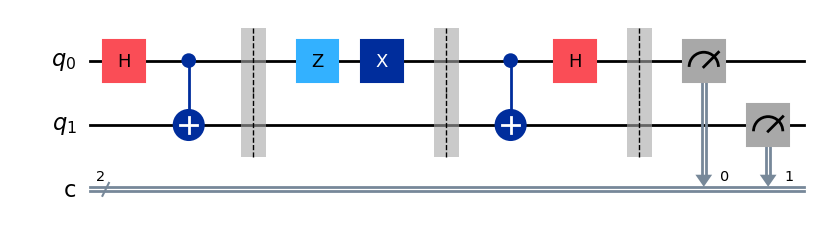

In [ ]:
# Step 1: Map problem to quantum circuits and operators
# Create 2-qubits circuit
qc=QuantumCircuit(2,2)

# Eve creates EPR pair and send q0 to Alice and q1 to Bob
qc.h(0)
qc.cx(0,1)
qc.barrier()

# set message which Alice wants to transform to Bob
msg = "11"    # You can change the message 

if msg == "00":
    pass
elif msg == "10":    
    qc.x(0)
elif msg == "01":    
    qc.z(0)
elif msg == "11":    
    qc.z(0)
    qc.x(0)
    
qc.barrier()   
# Bob receives EPR qubit from Alice and performs unitery operations
qc.cx(0,1)
qc.h(0)
qc.barrier()

# Bob measures q0 and q1
qc.measure(0,0)
qc.measure(1,1)

qc.draw(output="mpl")

In [ ]:
# We will execute on a simulator first
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler

# Define backend
backend = AerSimulator()
shots=1000

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)

# Run the job
sampler = Sampler(mode=backend)
job_sim = sampler.run([isa_qc], shots=shots)
result_sim = job_sim.result()

# Extract counts data
counts = result_sim[0].data.c.get_counts()
print(counts)

{'11': 1000}


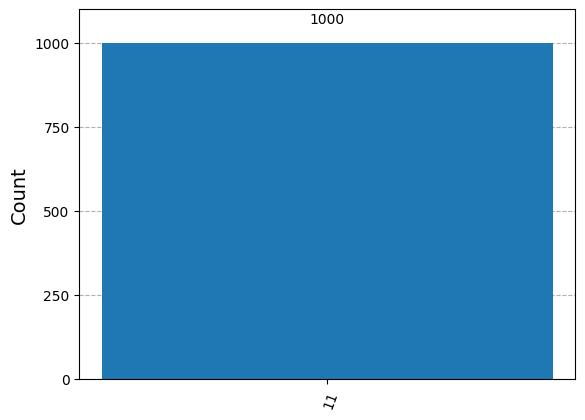

In [ ]:
# Visualize the results
from qiskit.visualization import plot_histogram
plot_histogram(counts)

BobはAliceが送りたかったメッセージを受け取ったことが分かります．

次に，本物の量子コンピューターで試してみましょう．

In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True)
print("The least busy device is ", backend)

The least busy device is  <IBMBackend('ibm_nazca')>


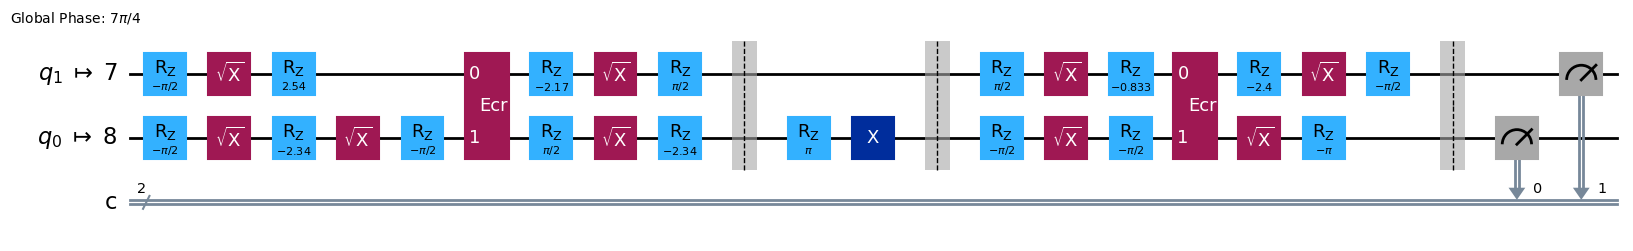

In [ ]:
# Step 1 was already completed before the simulator job above.
# Step 2: Optimize for target hardware
# Transpile the circuit into basis gates executable on the hardware
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qc)

qc_compiled.draw("mpl", idle_wires=False)

In [41]:
# Step 3:Execute the target circuit
sampler = Sampler(backend)
job = sampler.run([qc_compiled])
print("job id:", job.job_id())

job id: cvn75rzqy6cg0089a7m0


In [42]:
# Check the job status
job.status()

'RUNNING'

In [44]:
# If the Notebook session got disconnected you can also check your job statuse by running the following code
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()  
job = service.job('cvn75rzqy6cg0089a7m0') # Input your job-id between the quotations
job.status()

'DONE'

In [45]:
# Execute after job has successfully run
real_result= job.result()
print(real_result[0].data.c.get_counts())

{'11': 3984, '01': 72, '00': 10, '10': 30}


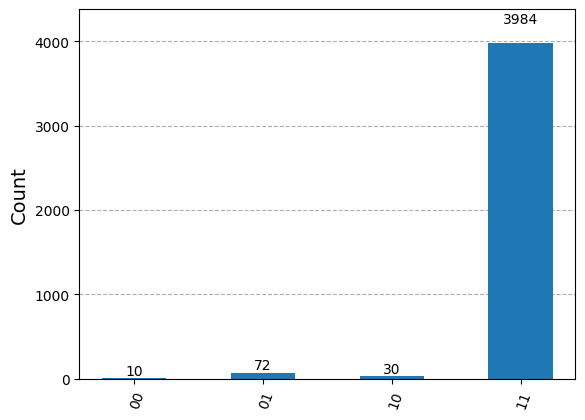

In [46]:
# Step 4: Postprocess the results
from qiskit.visualization import plot_histogram
plot_histogram(real_result[0].data.c.get_counts())

結果は予想通りでした．実調子コンピュータ上での超密度符号化は，実量子コンピュータ上での量子テレポーテーションの場合よりもエラーが少なかったです．この理由の一つは，量子テレポーテーションは動的回路を使用し，超密度符号化は使用しないためと考えられます．量子回路のエラーについては後のレッスンで詳しく学んでいきます．

## 7. まとめ

このセッションでは、2つの量子プロトコルを実装しました。両者とも、遠く離れた友人を対象としたシナリオで、1つのQPU上での量子計算とはやや離れているが、量子計算への応用が可能であり、量子情報の転送をより深く理解するのに役立つものです。

- **量子テレポーテーション**: 量子状態をコピーすることはできないが，エンタングルメントを共有することで未知の量子状態をテレポートすることができる．
- **量子超密度符号化**: エンタングルされたペアを共有し，1量子ビットを転送することで，２ビットの古典情報の通信が可能になる．


In [18]:
# See the version of Qiskit
import qiskit
qiskit.__version__

'1.3.0'